In [65]:
import argparse
import torch
from rdkit import Chem  
from rdkit.Chem import AllChem
import py3Dmol
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from dgl.nn import SumPooling, AvgPooling
from tensorboardX import SummaryWriter
from model.bgrl import BGRL
from model.edieggc import EDiEGGC
from data.data import QM9Dataloader
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
parser = argparse.ArgumentParser(description='dipole moment prediction training')
"""Experiment setting."""
parser.add_argument('--exp-name', type=str, default='qmugs_20_mmff_mu_g', help="")
parser.add_argument('--lacl', type=bool, default=True, help="True for training LACL, False for training")
parser.add_argument('--finetune', type=bool, default=False, help="")
parser.add_argument('--freeze', type=bool, default=False, help="")
parser.add_argument('--update_moving_average', type=bool, default=True, help="")
parser.add_argument('--loss', type=str, default='contrastive+prediction', help="")
parser.add_argument('--num-workers', type=int, default=6, help="")
parser.add_argument('--dataset', type=str, default='QM9', help="data-chemical")
parser.add_argument('--set', type=str, default='src', help="'src' for source domain and 'tgt' for target domain")
parser.add_argument('--target', type=str, default='gap', help="homo, lumo, gap, mu, ...")
parser.add_argument('--geometry', type=str, default='CGCF', help="")
parser.add_argument('--epochs', type=int, default=300, help="")
parser.add_argument('--num-train', type=int, default=110000, help="110000/65000")
parser.add_argument('--num-valid', type=int, default=10000, help="10000/1500")
parser.add_argument('--num-test', type=int, default=10829, help="10829/1706")
parser.add_argument('--batch-size', type=int, default=32, help="")
parser.add_argument('--learning-rate', type=float, default=1e-3, help="")
parser.add_argument('--weight-decay', type=float, default=0, help="")
parser.add_argument('--max-norm', type=float, default=1000.0, help="")
parser.add_argument('--scheduler', type=str, default='plateau', help="")
parser.add_argument('--cutoff', type=float, default=4.0, help="")
parser.add_argument('--device', type=str, default='cuda', help="cuda device")
'''Model setting'''
parser.add_argument('--embedding-type', type=str, default='cgcnn', help="")
parser.add_argument('--alignn-layers', type=int, default=4, help="")
parser.add_argument('--gcn-layers', type=int, default=4, help="")
parser.add_argument('--atom-input-features', type=int, default=92, help="")
parser.add_argument('--edge-input-features', type=int, default=80, help="")
parser.add_argument('--triplet-input-features', type=int, default=40, help="")
parser.add_argument('--embedding-features', type=int, default=64, help="")
parser.add_argument('--hidden-features', type=int, default=256, help="")
parser.add_argument('--output-features', type=int, default=1, help="")
args = parser.parse_args([])

In [56]:
# Prepare data
train_loader, valid_loader, test_loader, test_indices = QM9Dataloader(args)
del train_loader, valid_loader

100%|██████████| 133855/133855 [02:33<00:00, 873.11it/s] 


In [57]:
# Load model
bgrl_trained_model = BGRL(args).to(args.device)
bgrl_trained_model.load_state_dict(torch.load('ckpts/qm9_cgcf_lumo_b'))  # Change relative path of saved model
bgrl_trained_model.eval()   

alignn_trained_model = EDiEGGC(args).to(args.device)
alignn_trained_model.load_state_dict(torch.load('ckpts/qm9_cgcf_lumo_g'))  # Change relative path of saved model
alignn_trained_model.eval()

EDiEGGC(
  (encoder): Encoder(
    (atom_embedding): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=92, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (edge_embedding): Sequential(
      (0): RBFExpansion()
      (1): MLPLayer(
        (layer): Sequential(
          (0): Linear(in_features=80, out_features=64, bias=True)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (2): MLPLayer(
        (layer): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
    )
    (angle_embedding): Sequential(
      (0): RBFExpansion()
      (1): MLPLayer(
        (layer): Sequential(
          (0): Linear(in_features=40

Get embeddings

In [58]:
pooling = AvgPooling()
# Get atomic embeddings of test set
bgrl_trained_x_embs_1 = torch.tensor([]).to(args.device)
alignn_trained_x_embs_1 = torch.tensor([]).to(args.device)
bgrl_trained_x_embs_2 = torch.tensor([]).to(args.device)
alignn_trained_x_embs_2 = torch.tensor([]).to(args.device)
# Get molecule embeddings of test set
bgrl_trained_g_embs_1 = torch.tensor([]).to(args.device)
alignn_trained_g_embs_1 = torch.tensor([]).to(args.device)
bgrl_trained_g_embs_2 = torch.tensor([]).to(args.device)
alignn_trained_g_embs_2 = torch.tensor([]).to(args.device)

for g1, lg1, g2, lg2, labels in tqdm(test_loader):
    g1 = g1.to(args.device)
    lg1 = lg1.to(args.device)
    g2 = g2.to(args.device)
    lg2 = lg2.to(args.device)
    labels = labels.to(args.device)
    with torch.no_grad():
        pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g1, lg1, g2, lg2)
        g_embs = pooling(g1, x)
        bgrl_trained_g_embs_1 = torch.concat([bgrl_trained_g_embs_1, g_embs.detach()])
        bgrl_trained_x_embs_1 = torch.concat([bgrl_trained_x_embs_1, x.detach()])
        pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g2, lg2, g2, lg2)
        g_embs = pooling(g1, x)
        bgrl_trained_g_embs_2 = torch.concat([bgrl_trained_g_embs_2, g_embs.detach()])
        bgrl_trained_x_embs_2 = torch.concat([bgrl_trained_x_embs_2, x.detach()])
        pred, v, x, y, z = alignn_trained_model(g1, lg1)
        g_embs = pooling(g1, x)
        alignn_trained_g_embs_1 = torch.concat([alignn_trained_g_embs_1, g_embs.detach()])
        alignn_trained_x_embs_1 = torch.concat([alignn_trained_x_embs_1, x.detach()])
        pred, v, x, y, z = alignn_trained_model(g2, lg2)
        g_embs = pooling(g1, x)
        alignn_trained_g_embs_2 = torch.concat([alignn_trained_g_embs_2, g_embs.detach()])
        alignn_trained_x_embs_2 = torch.concat([alignn_trained_x_embs_2, x.detach()])

100%|██████████| 339/339 [01:34<00:00,  3.57it/s]


In [59]:
bgrl_trained_x_embs_1 = bgrl_trained_x_embs_1.cpu()
alignn_trained_x_embs_1 = alignn_trained_x_embs_1.cpu()
bgrl_trained_x_embs_2 = bgrl_trained_x_embs_2.cpu()
alignn_trained_x_embs_2 = alignn_trained_x_embs_2.cpu()

bgrl_trained_g_embs_1 = bgrl_trained_g_embs_1.cpu()
alignn_trained_g_embs_1 = alignn_trained_g_embs_1.cpu()
bgrl_trained_g_embs_2 = bgrl_trained_g_embs_2.cpu()
alignn_trained_g_embs_2 = alignn_trained_g_embs_2.cpu()

bgrl_trained_model = bgrl_trained_model.to('cpu')
alignn_trained_model = alignn_trained_model.to('cpu')

In [60]:
atom_numbers = torch.tensor([])
label_list = torch.tensor([])
for g1, lg1, g2, lg2, labels in tqdm(test_loader):
    atom_numbers = torch.concat([atom_numbers, g1.ndata['atom_numbers']])
    label_list = torch.concat([label_list, labels])

100%|██████████| 339/339 [00:09<00:00, 34.14it/s]


In [19]:
# Node embedding의 PCA
pca_model = PCA(n_components=2)
alignn_trained_g_pca_1 = pca_model.fit_transform(alignn_trained_g_embs_1)
alignn_trained_g_pca_2 = pca_model.fit_transform(alignn_trained_g_embs_2)
bgrl_trained_g_pca_1 = pca_model.fit_transform(bgrl_trained_g_embs_1)
bgrl_trained_g_pca_2 = pca_model.fit_transform(bgrl_trained_g_embs_2)

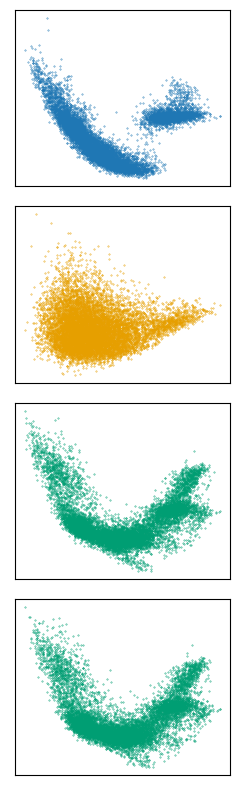

In [38]:
plt.figure(figsize=(2.5, 8))
ax1 = plt.subplot(4,1,1)
g_pca_atom = alignn_trained_g_pca_1
plt.scatter(g_pca_atom[:,0], g_pca_atom[:,1], s=0.1, )
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,2)
g_pca_atom = alignn_trained_g_pca_2
plt.scatter(g_pca_atom[:,0], g_pca_atom[:,1], c='#E69F00', s=0.1, )
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,3)
g_pca_atom = bgrl_trained_g_pca_1
plt.scatter(g_pca_atom[:,0], g_pca_atom[:,1], c='#009E73', s=0.1, )
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,4)
g_pca_atom = bgrl_trained_g_pca_2
plt.scatter(g_pca_atom[:,0], g_pca_atom[:,1], c='#009E73', s=0.1, )
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

plt.tight_layout()
plt.savefig(f'images/figure_1_pca_{args.geometry.lower()}_{args.target}.pdf', dpi=500, format='pdf', transparent=True)
plt.savefig(f'images/figure_1_pca_{args.geometry.lower()}_{args.target}.tif', dpi=500, format='tif', transparent=True)

In [21]:
pd.DataFrame({
    'source-finetune-source-x':alignn_trained_g_pca_1[:,0], 'source-finetune-source-y':alignn_trained_g_pca_1[:,1],
    'source-finetune-target-x':alignn_trained_g_pca_2[:,0], 'source-finetune-target-y':alignn_trained_g_pca_2[:,1],
    'lacl-source-x':bgrl_trained_g_pca_1[:,0], 'lacl-source-y':bgrl_trained_g_pca_1[:,1],
    'lacl-target-x':bgrl_trained_g_pca_2[:,0], 'lacl-target-y':bgrl_trained_g_pca_2[:,1],
}).to_csv(f'figure_1_pca_{args.target}.csv')


In [61]:
# node embedding t-sne visualization
tsne_model = TSNE(n_components=2, perplexity=50)
alignn_trained_x_tsne_1 = tsne_model.fit_transform(alignn_trained_x_embs_1[:10000])
alignn_trained_x_tsne_2 = tsne_model.fit_transform(alignn_trained_x_embs_2[:10000])
bgrl_trained_x_tsne_1 = tsne_model.fit_transform(bgrl_trained_x_embs_1[:10000])
bgrl_trained_x_tsne_2 = tsne_model.fit_transform(bgrl_trained_x_embs_2[:10000])

/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anacond

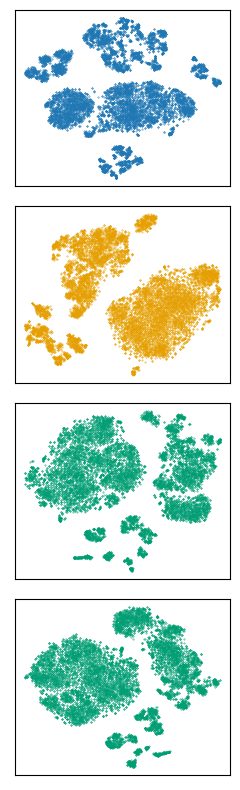

In [62]:
plt.figure(figsize=(2.5, 8))
ax1 = plt.subplot(4,1,1)
plt.scatter(alignn_trained_x_tsne_1[:,0], alignn_trained_x_tsne_1[:,1], s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)
# plt.colorbar()

ax1 = plt.subplot(4,1,2)
plt.scatter(alignn_trained_x_tsne_2[:,0], alignn_trained_x_tsne_2[:,1], c='#E69F00', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,3)
plt.scatter(bgrl_trained_x_tsne_1[:,0], bgrl_trained_x_tsne_1[:,1], c='#009E73', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,4)
plt.scatter(bgrl_trained_x_tsne_2[:,0], bgrl_trained_x_tsne_2[:,1], c='#009E73', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

plt.tight_layout()
plt.savefig(f'images/extended_data_2b_tsne_x_{args.geometry.lower()}_{args.target}.pdf', dpi=500, format='pdf', transparent=True)
plt.savefig(f'images/extended_data_2b_tsne_x_{args.geometry.lower()}_{args.target}.tif', dpi=500, format='tif', transparent=True)

In [51]:
pd.DataFrame({
    'source-finetune-source-x':alignn_trained_x_tsne_1[:,0], 'source-finetune-source-y':alignn_trained_x_tsne_1[:,1],
    'source-finetune-target-x':alignn_trained_x_tsne_2[:,0], 'source-finetune-target-y':alignn_trained_x_tsne_2[:,1],
    'lacl-source-x':bgrl_trained_x_tsne_1[:,0], 'lacl-source-y':bgrl_trained_x_tsne_1[:,1],
    'lacl-target-x':bgrl_trained_x_tsne_2[:,0], 'lacl-target-y':bgrl_trained_x_tsne_2[:,1],
}).to_csv(f'images/extended_data_2b_tsne_x_{args.target}.csv')

In [63]:
# node 단위로 embedding t-sne visualization
tsne_model = TSNE(n_components=2, perplexity=50)
alignn_trained_g_tsne_1 = tsne_model.fit_transform(alignn_trained_g_embs_1[:10000])
alignn_trained_g_tsne_2 = tsne_model.fit_transform(alignn_trained_g_embs_2[:10000])
bgrl_trained_g_tsne_1 = tsne_model.fit_transform(bgrl_trained_g_embs_1[:10000])
bgrl_trained_g_tsne_2 = tsne_model.fit_transform(bgrl_trained_g_embs_2[:10000])

/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anacond

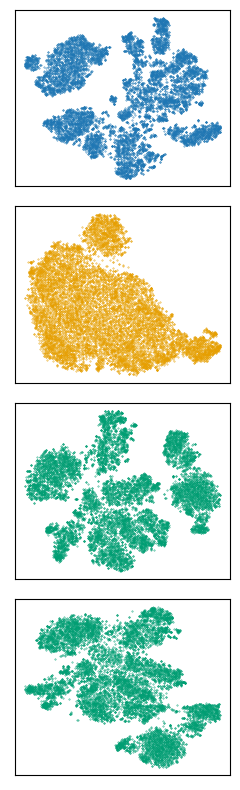

In [64]:
plt.figure(figsize=(2.5, 8))
ax1 = plt.subplot(4,1,1)
plt.scatter(alignn_trained_g_tsne_1[:,0], alignn_trained_g_tsne_1[:,1], s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)
# plt.colorbar()

ax1 = plt.subplot(4,1,2)
plt.scatter(alignn_trained_g_tsne_2[:,0], alignn_trained_g_tsne_2[:,1], c='#E69F00', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,3)
plt.scatter(bgrl_trained_g_tsne_1[:,0], bgrl_trained_g_tsne_1[:,1], c='#009E73', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

ax1 = plt.subplot(4,1,4)
plt.scatter(bgrl_trained_g_tsne_2[:,0], bgrl_trained_g_tsne_2[:,1], c='#009E73', s=0.1)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)

plt.tight_layout()
plt.savefig(f'images/extended_data_2b_tsne_g_{args.geometry.lower()}_{args.target}.pdf', dpi=500, format='pdf', transparent=True)
plt.savefig(f'images/extended_data_2b_tsne_g_{args.geometry.lower()}_{args.target}.tif', dpi=500, format='tif', transparent=True)

In [54]:
pd.DataFrame({
    'source-finetune-source-x':alignn_trained_g_tsne_1[:,0], 'source-finetune-source-y':alignn_trained_g_tsne_1[:,1],
    'source-finetune-target-x':alignn_trained_g_tsne_2[:,0], 'source-finetune-target-y':alignn_trained_g_tsne_2[:,1],
    'lacl-source-x':bgrl_trained_g_tsne_1[:,0], 'lacl-source-y':bgrl_trained_g_tsne_1[:,1],
    'lacl-target-x':bgrl_trained_g_tsne_2[:,0], 'lacl-target-y':bgrl_trained_g_tsne_2[:,1],
}).to_csv(f'images/extended_data_2b_tsne_g_{args.target}.csv')

In [84]:
# node embedding t-sne visualization
tsne_model = TSNE(n_components=2, perplexity=50)
# alignn_trained_x_tsne_1 = tsne_model.fit_transform(alignn_trained_x_embs_1)
# alignn_trained_x_tsne_2 = tsne_model.fit_transform(alignn_trained_x_embs_2)
bgrl_trained_x_tsne_1 = tsne_model.fit_transform(bgrl_trained_x_embs_1[:30000])
# bgrl_trained_x_tsne_2 = tsne_model.fit_transform(bgrl_trained_x_embs_2)

/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [66]:
with open('data/QM9/qm9_all.pkl', 'rb') as f:
    qm9 = pickle.load(f)

smiles = []
for i in tqdm(test_indices[2]):
    qm9_i = qm9[i]
    for z in qm9_i['z']:
        smiles.append(qm9_i['SMILES']+', '+str(z))

writer = SummaryWriter(log_dir='runs/test')
writer.add_embedding(bgrl_trained_x_tsne_1, metadata=smiles, global_step=0, tag='bgrl_trained_x_tsne_1')
writer.add_embedding(alignn_trained_x_tsne_1, metadata=smiles, global_step=0, tag='alignn_trained_x_tsne_1')

100%|██████████| 10829/10829 [00:00<00:00, 55346.72it/s]


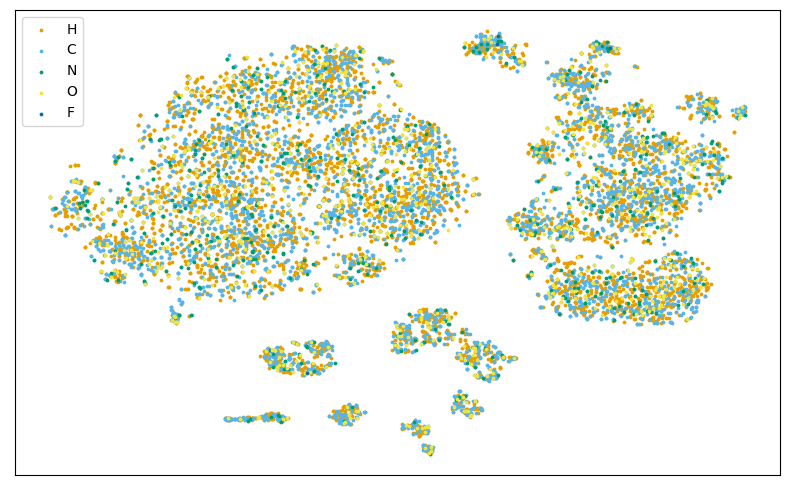

In [90]:
plt.figure(figsize=(8,5))
# plt.scatter(bgrl_trained_x_tsne_1[:,0], bgrl_trained_x_tsne_1[:,1], c='#009E73', s=0.1)
x_tsne_atom = np.hstack([bgrl_trained_x_tsne_1, atom_numbers[:,None].numpy()[:10000]])
x_tsne_1 = x_tsne_atom[x_tsne_atom[:, 2]==1]
x_tsne_6 = x_tsne_atom[x_tsne_atom[:, 2]==6]
x_tsne_7 = x_tsne_atom[x_tsne_atom[:, 2]==7]
x_tsne_8 = x_tsne_atom[x_tsne_atom[:, 2]==8]
x_tsne_9 = x_tsne_atom[x_tsne_atom[:, 2]==9]
plt.scatter(x_tsne_1[:,0], x_tsne_1[:,1], s=3, label='H', c="#E69F00")
plt.scatter(x_tsne_6[:,0], x_tsne_6[:,1], s=3, label='C', c="#56B4E9")
plt.scatter(x_tsne_7[:,0], x_tsne_7[:,1], s=3, label='N', c="#009E73")
plt.scatter(x_tsne_8[:,0], x_tsne_8[:,1], s=3, label='O', c="#F0E442")
plt.scatter(x_tsne_9[:,0], x_tsne_9[:,1], s=3, label='F', c="#0072B2")
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tick_params(width=0)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f'images/extended_data_2a_tsne_x_{args.geometry.lower()}_{args.target}.pdf', dpi=500, format='pdf', transparent=True)
plt.savefig(f'images/extended_data_2a_tsne_x_{args.geometry.lower()}_{args.target}.tif', dpi=500, format='tif', transparent=True)

In [ ]:
!tensorboard --logdir=runs/test

In [113]:
pd.DataFrame({
    'atom_tsne_x':x_tsne_atom[:,0], 'atom_tsne_y':x_tsne_atom[:,1], 'atom_numbers':x_tsne_atom[:,2],
}).to_csv(f'images/extended_data_2a_tsne_x_{args.target}.csv')

In [111]:

test_mol_list = [
    'CC(C)CC1(CO1)C#N',
    'CC1C(CO)NC1C#N',
    'CC1(O)C2CC1(O)CO2',
    'NC1=NC(CC=O)=CO1',
    'OC1C2COCC12C=O'
]
mol = Chem.MolFromSmiles(test_mol_list[4])
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
view = py3Dmol.view(width=800, height=600, data=Chem.MolToMolBlock(mol), style={"stick": {}, "sphere": {"scale": 0.3}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol